# 05. 고급 모델 비교 및 하이퍼파라미터 튜닝

**목표**: 여러 알고리즘 비교 및 최적 모델 선정

## 📋 작업 계획

1. 데이터 로드
2. 여러 모델 비교
   - Ridge Regression
   - Lasso Regression
   - Random Forest
   - Gradient Boosting
3. Cross-Validation
4. 하이퍼파라미터 튜닝 (GridSearch)
5. 최적 모델 선정 및 저장

## 1. 라이브러리 및 데이터 로드

In [59]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from time import time

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# 프로젝트 루트 경로 추가
sys.path.append('..')

from utils.evaluation import evaluate_model, compare_models, create_model_comparison_plot

print("라이브러리 로드 완료!")

라이브러리 로드 완료!


In [60]:
# 데이터 로드
X_train = pd.read_csv('data/final/X_train.csv')
X_val = pd.read_csv('data/final/X_val.csv')
X_test = pd.read_csv('data/final/X_test.csv')

y_train = pd.read_csv('data/final/y_train.csv')['audiAcc']
y_val = pd.read_csv('data/final/y_val.csv')['audiAcc']
y_test = pd.read_csv('data/final/y_test.csv')['audiAcc']

print("데이터 로드 완료!")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

데이터 로드 완료!
Train: (876, 46), Val: (188, 46), Test: (188, 46)


## 2. 여러 모델 비교

### 2.1 모델 정의

In [61]:
# XGBoost 또는 LightGBM 사용
import xgboost as xgb
from lightgbm import LGBMRegressor

# 비교할 모델들 정의
models = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42, max_iter=10000),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
          n_estimators=200,
          max_depth=7,
          learning_rate=0.05,
          random_state=42
      ),
      'LightGBM': LGBMRegressor(
          n_estimators=200,
          max_depth=7,
          learning_rate=0.05,
          random_state=42
      )
}

print(f"비교할 모델 수: {len(models)}")
for name in models.keys():
    print(f"  - {name}")

비교할 모델 수: 6
  - Ridge
  - Lasso
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM


### 2.2 모델 학습 및 평가

In [62]:
# 결과 저장용
results = {}
trained_models = {}

print("모델 학습 및 평가 시작...\n")

for name, model in models.items():
    print(f"=== {name} ===")
    
    # 학습 시간 측정
    start_time = time()
    
    # Cross-Validation (5-Fold)
    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    cv_rmse = np.sqrt(-cv_scores.mean())
    cv_std = np.sqrt(cv_scores.std())
    
    # 전체 Train 데이터로 학습
    model.fit(X_train, y_train)
    
    training_time = time() - start_time
    
    # Validation 예측
    y_val_pred = model.predict(X_val)
    
    # 평가 지표 계산
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # 결과 저장
    results[name] = {
        'CV_RMSE': cv_rmse,
        'CV_Std': cv_std,
        'Val_RMSE': val_rmse,
        'Val_MAE': val_mae,
        'Val_R2': val_r2,
        'Training_Time': training_time
    }
    
    trained_models[name] = model
    
    # 출력
    print(f"  CV RMSE: {cv_rmse:,.0f} (+/- {cv_std:,.0f})")
    print(f"  Val RMSE: {val_rmse:,.0f}")
    print(f"  Val MAE: {val_mae:,.0f}")
    print(f"  Val R²: {val_r2:.3f}")
    print(f"  Training Time: {training_time:.2f}s")
    print()

print("\n모든 모델 학습 완료!")

모델 학습 및 평가 시작...

=== Ridge ===
  CV RMSE: 1,037,681 (+/- 552,345)
  Val RMSE: 1,284,301
  Val MAE: 604,349
  Val R²: 0.497
  Training Time: 1.60s

=== Lasso ===
  CV RMSE: 1,044,299 (+/- 542,424)
  Val RMSE: 1,289,143
  Val MAE: 607,090
  Val R²: 0.493
  Training Time: 1.99s

=== Random Forest ===
  CV RMSE: 1,042,431 (+/- 624,714)
  Val RMSE: 1,408,307
  Val MAE: 433,543
  Val R²: 0.395
  Training Time: 0.55s

=== Gradient Boosting ===
  CV RMSE: 1,078,694 (+/- 772,698)
  Val RMSE: 1,515,961
  Val MAE: 481,693
  Val R²: 0.299
  Training Time: 1.25s

=== XGBoost ===
  CV RMSE: 1,219,340 (+/- 793,681)
  Val RMSE: 1,407,047
  Val MAE: 438,438
  Val R²: 0.396
  Training Time: 0.53s

=== LightGBM ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Auto-choosing c

### 2.3 모델 성능 비교

In [63]:
# 결과 DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Val_MAE', ascending=True)  # MAE는 낮을수록 좋음

print("=== 모델 성능 비교 (MAE 기준) ===")
print(results_df)

# 최고 성능 모델 (MAE가 가장 낮은 모델)
best_model_name = results_df.index[0]
print(f"\n🏆 최고 성능 모델: {best_model_name}")
print(f"   Validation MAE: {results_df.loc[best_model_name, 'Val_MAE']:,.0f} 명")

=== 모델 성능 비교 (MAE 기준) ===
                        CV_RMSE         CV_Std      Val_RMSE        Val_MAE  \
LightGBM           1.042100e+06  620392.111478  1.323662e+06  425424.998629   
Random Forest      1.042431e+06  624714.264667  1.408307e+06  433543.060054   
XGBoost            1.219340e+06  793680.774085  1.407047e+06  438438.312500   
Gradient Boosting  1.078694e+06  772698.355695  1.515961e+06  481693.454218   
Ridge              1.037681e+06  552345.255171  1.284301e+06  604348.796562   
Lasso              1.044299e+06  542423.675315  1.289143e+06  607090.409539   

                     Val_R2  Training_Time  
LightGBM           0.465402       1.627821  
Random Forest      0.394844       0.554599  
XGBoost            0.395926       0.527025  
Gradient Boosting  0.298789       1.249033  
Ridge              0.496723       1.600755  
Lasso              0.492921       1.989085  

🏆 최고 성능 모델: LightGBM
   Validation MAE: 425,425 명


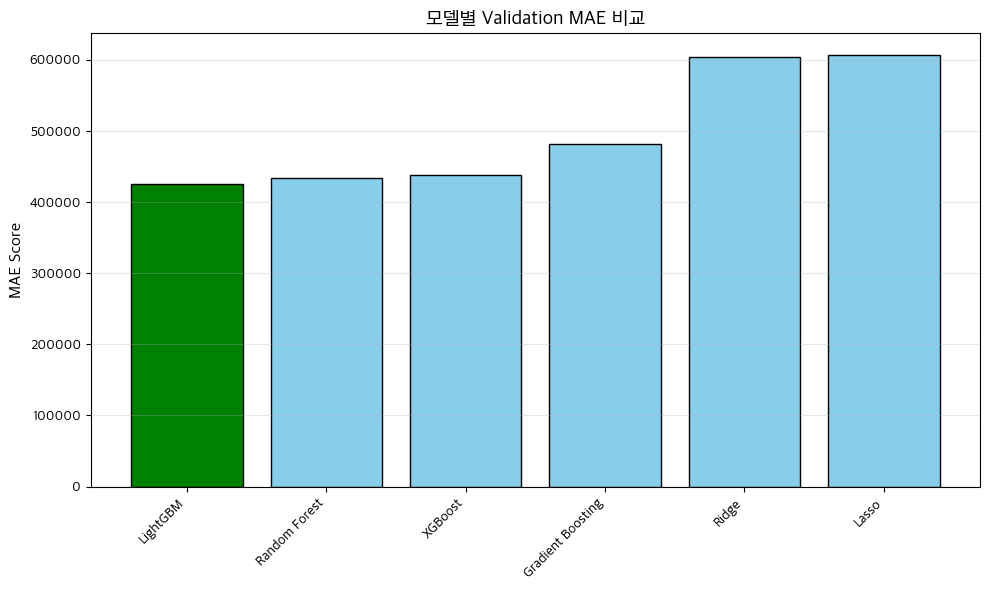

In [64]:
# 시각화: R² 비교
plt.figure(figsize=(10, 6))
colors = ['green' if i == 0 else 'skyblue' for i in range(len(results_df))]
plt.bar(range(len(results_df)), results_df['Val_MAE'], color=colors, edgecolor='black')
plt.xticks(range(len(results_df)), results_df.index, rotation=45, ha='right')
plt.ylabel('MAE Score', fontsize=12)
plt.title('모델별 Validation MAE 비교', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

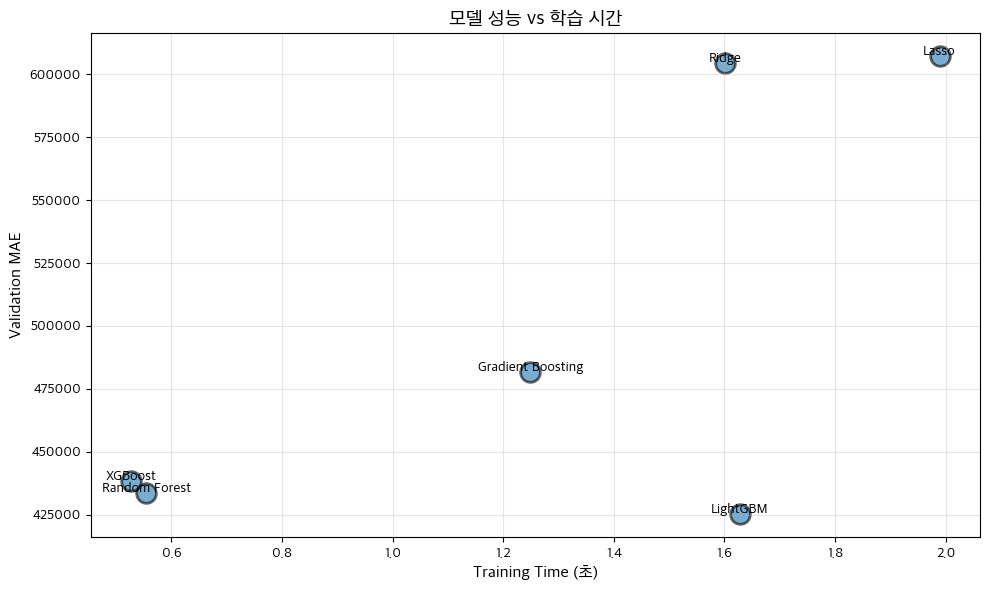

In [65]:
# 시각화: RMSE vs Training Time
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    results_df['Training_Time'],
    results_df['Val_MAE'],
    s=200,
    alpha=0.6,
    edgecolors='k',
    linewidth=2
)

# 모델명 표시
for idx, name in enumerate(results_df.index):
    plt.annotate(
        name,
        (results_df['Training_Time'].iloc[idx], results_df['Val_MAE'].iloc[idx]),
        fontsize=10,
        ha='center'
    )

plt.xlabel('Training Time (초)', fontsize=12)
plt.ylabel('Validation MAE', fontsize=12)
plt.title('모델 성능 vs 학습 시간', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. 하이퍼파라미터 튜닝

### 3.1 최고 성능 모델 튜닝

In [66]:
# 튜닝할 모델 선택 (성능이 좋은 모델)
# Random Forest와 Gradient Boosting을 튜닝하는 예시

print(f"하이퍼파라미터 튜닝 대상: Random Forest")

# Random Forest 파라미터 그리드
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\nGridSearch 시작 (시간이 오래 걸릴 수 있습니다...)")

# GridSearchCV
rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print("\nGridSearch 완료!")
print(f"최적 파라미터: {rf_grid_search.best_params_}")
print(f"최적 CV RMSE: {np.sqrt(-rf_grid_search.best_score_):,.0f}")

하이퍼파라미터 튜닝 대상: Random Forest

GridSearch 시작 (시간이 오래 걸릴 수 있습니다...)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

GridSearch 완료!
최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
최적 CV RMSE: 1,013,648


In [67]:
# 최적 모델로 Validation 평가
best_rf_model = rf_grid_search.best_estimator_
y_val_pred_tuned = best_rf_model.predict(X_val)

tuned_metrics = evaluate_model(
    y_val,
    y_val_pred_tuned,
    model_name='Tuned Random Forest'
)


=== Tuned Random Forest Performance ===
RMSE: 1,437,151 명
MAE: 434,058 명
R²: 0.370
MAPE: 207.52%


### 3.2 Gradient Boosting 튜닝 (선택사항)

In [68]:
# Gradient Boosting도 튜닝 (시간이 오래 걸릴 수 있음)
print("Gradient Boosting 하이퍼파라미터 튜닝...")

gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

gb_grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=3,  # 시간 절약을 위해 3-fold
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_train, y_train)

print("\nGradient Boosting 튜닝 완료!")
print(f"최적 파라미터: {gb_grid_search.best_params_}")

# 평가
best_gb_model = gb_grid_search.best_estimator_
y_val_pred_gb = best_gb_model.predict(X_val)

gb_metrics = evaluate_model(
    y_val,
    y_val_pred_gb,
    model_name='Tuned Gradient Boosting'
)

Gradient Boosting 하이퍼파라미터 튜닝...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

Gradient Boosting 튜닝 완료!
최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}

=== Tuned Gradient Boosting Performance ===
RMSE: 1,515,961 명
MAE: 481,693 명
R²: 0.299
MAPE: 352.00%


## 4. 최종 모델 선정

In [69]:
# 튜닝된 모델들과 기본 모델 비교
final_comparison = {
    'Ridge': results['Ridge'],
    'LightGBM (기본)': results['LightGBM'],
    'Random Forest (기본)': results['Random Forest'],
    'Tuned Random Forest': {
        'Val_RMSE': tuned_metrics['RMSE'],
        'Val_MAE': tuned_metrics['MAE'],
        'Val_R2': tuned_metrics['R2']
    },
    'Gradient Boosting (기본)': results['Gradient Boosting'],
    'Tuned Gradient Boosting': {
        'Val_RMSE': gb_metrics['RMSE'],
        'Val_MAE': gb_metrics['MAE'],
        'Val_R2': gb_metrics['R2']
    }
}

comparison_df = pd.DataFrame(final_comparison).T
comparison_df = comparison_df.sort_values('Val_MAE', ascending=True)  # MAE 기준 정렬

print("=== 최종 모델 비교 (MAE 기준) ===")
print(comparison_df[['Val_RMSE', 'Val_MAE', 'Val_R2']])

# 최종 모델 선정 (MAE가 가장 낮은 모델)
final_model_name = comparison_df.index[0]
print(f"\n🏆 최종 선정 모델: {final_model_name}")
print(f"   Validation MAE: {comparison_df.loc[final_model_name, 'Val_MAE']:,.0f} 명")
print(f"   Validation R²: {comparison_df.loc[final_model_name, 'Val_R2']:.3f}")

=== 최종 모델 비교 (MAE 기준) ===
                             Val_RMSE        Val_MAE    Val_R2
LightGBM (기본)            1.323662e+06  425424.998629  0.465402
Random Forest (기본)       1.408307e+06  433543.060054  0.394844
Tuned Random Forest      1.437151e+06  434057.533098  0.369800
Gradient Boosting (기본)   1.515961e+06  481693.454218  0.298789
Tuned Gradient Boosting  1.515961e+06  481693.454218  0.298789
Ridge                    1.284301e+06  604348.796562  0.496723

🏆 최종 선정 모델: LightGBM (기본)
   Validation MAE: 425,425 명
   Validation R²: 0.465


In [70]:
# 최종 모델 결정
if 'Tuned Random Forest' in final_model_name:
    final_model = best_rf_model
elif 'Tuned Gradient Boosting' in final_model_name:
    final_model = best_gb_model
elif 'Random Forest' in final_model_name:
    final_model = trained_models['Random Forest']
elif 'LightGBM' in final_model_name:
    final_model = trained_models['LightGBM']
elif 'XGBoost' in final_model_name:
    final_model = trained_models['XGBoost']
else:
    final_model = trained_models[final_model_name]

print(f"최종 모델 저장 준비 완료: {type(final_model).__name__}")

최종 모델 저장 준비 완료: LGBMRegressor


## 5. 모델 저장

In [71]:
# 최종 모델 저장
joblib.dump(final_model, 'models/best_model.pkl')

# GridSearch 객체도 저장 (파라미터 정보 포함)
joblib.dump(rf_grid_search, 'models/rf_grid_search.pkl')
joblib.dump(gb_grid_search, 'models/gb_grid_search.pkl')

# 성능 결과 저장
comparison_df.to_csv('results/tables/model_comparison.csv')

print("모델 및 결과 저장 완료!")
print("  - models/best_model.pkl")
print("  - models/rf_grid_search.pkl")
print("  - models/gb_grid_search.pkl")
print("  - results/tables/model_comparison.csv")

모델 및 결과 저장 완료!
  - models/best_model.pkl
  - models/rf_grid_search.pkl
  - models/gb_grid_search.pkl
  - results/tables/model_comparison.csv


## 6. 요약

In [72]:
print("\n" + "="*60)
print("고급 모델링 요약")
print("="*60)

print("\n📊 비교한 모델")
for name in models.keys():
    print(f"  - {name}")

print("\n🏆 최종 선정 모델 (MAE 기준)")
print(f"  모델: {final_model_name}")
print(f"  Validation MAE: {comparison_df.loc[final_model_name, 'Val_MAE']:,.0f} 명")
print(f"  Validation RMSE: {comparison_df.loc[final_model_name, 'Val_RMSE']:,.0f} 명")
print(f"  Validation R²: {comparison_df.loc[final_model_name, 'Val_R2']:.3f}")

print("\n📈 성능 개선")
baseline_mae = results['Ridge']['Val_MAE']  # Ridge를 baseline으로 가정
improvement = (baseline_mae - comparison_df.loc[final_model_name, 'Val_MAE']) / baseline_mae * 100
print(f"  Baseline 대비 MAE 개선: {improvement:+.1f}%")

print("\n" + "="*60)
print("✅ 고급 모델링 완료!")
print("다음 단계: 06_evaluation_interpretation.ipynb")
print("="*60)


고급 모델링 요약

📊 비교한 모델
  - Ridge
  - Lasso
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM

🏆 최종 선정 모델 (MAE 기준)
  모델: LightGBM (기본)
  Validation MAE: 425,425 명
  Validation RMSE: 1,323,662 명
  Validation R²: 0.465

📈 성능 개선
  Baseline 대비 MAE 개선: +29.6%

✅ 고급 모델링 완료!
다음 단계: 06_evaluation_interpretation.ipynb
